# Recurrent Neural Networks

* 어바웃 파이썬
* 김성근

----------------------

- https://www.slideshare.net/ByoungHeeKim1/recurrent-neural-networks-73629152 (이거 짱 잘정리되어있음)
- RNN은 시퀀스를 가진(ex 시계열데이터) 데이터를 입력으로 받아 작동하는 네트워크
- 인풋의 길이가 고정되어있거나 가변인경우 모두 가능
- 자연어 처리나 번역 감성분석 등에도 활용이 가능함
- 음악의 멜로디등을 받아 다음에 이어질 멜로디를 맞출수도 있음: https://tykimos.github.io/2017/04/09/RNN_Layer_Talk/
- 문장을 만들어내거나 이미지 캡션도 가능함

![rnn_cell](http://cfile7.uf.tistory.com/image/21140B4757AC18710FDB44)

![f_1](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTnngtRxwGkHevut1Q-CVq8R0Xq78hw3g_5TDsioMu9q6bsV6h2)

![RNN](http://i.imgur.com/Q8zv6TQ.png)

## Memory cells
- t시점의 아웃풋은 모든 전시점의 아웃풋의 함수이므로 메모리의 형태라고 할 수 있음
- 이를 기본 RNN이라하는데 이보다 파워풀한 cell도 있음 뒤에서 배울것임

## Input and Output Sequences
- 시퀀스 벡터를 입력으로 받을수 있다. 영화리뷰를 받아서 감성점수를 산출할 수 있음
- 입력을 이미지로 받아서 출력을 이미지에 대한 캡션을 만들수 있음
- 디코더라 불리는 vector-tosequence network, called a decoder에 따라오는 인코더라 불리는 sequence-to-vector network도 가능함
- 인코더-디코더는 문장을 다른 문장으로 번역할 수 있음

## RNN를 만들어보자!!
### 1. mnist 예제

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.recurrent import SimpleRNN, LSTM, GRU 
from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

- 데이터를 다운받아 트레인, 테스트 셋으로 나눠줌

In [81]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
n_classes = 10

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one-hot encoding:
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

print('train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)

train: 60000 test: 10000
X_train: (60000, 28, 28)
Y_train: (60000, 10)


- 28*28사이즈의 어레이가 인풋이고, 맞춰야하는 아웃풋은 0-9까지 10가지임
- 시퀀스의 형태 : SimpleRNN(input_shape=(28, 28))
- 분류 결과는 10개중 하나 : Dense(units=10)
- 다중 분류니깐 : Activation('softmax')

In [72]:
n_hidden = 100

model = Sequential()
model.add(SimpleRNN(n_hidden,input_shape=(28, 28)))
model.add(Dense(units=n_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 100)               12900     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 13,910
Trainable params: 13,910
Non-trainable params: 0
_________________________________________________________________


In [84]:
epochs = 3

history = model.fit(X_train, Y_train, 
                    epochs=epochs,batch_size=128,verbose=1)

Epoch 1/3
60000/60000 [==============================] - 13s - loss: 0.1258 - acc: 0.9632    
Epoch 2/3
60000/60000 [==============================] - 15s - loss: 0.1158 - acc: 0.9656    
Epoch 3/3
60000/60000 [==============================] - 13s - loss: 0.1061 - acc: 0.9688    


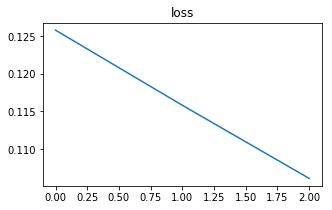

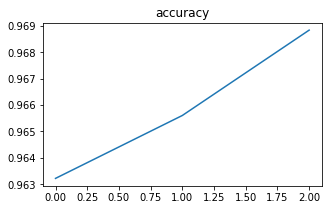

In [85]:
%matplotlib inline
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy');

In [86]:
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 96.28%


## 2. 멜로디를 생성해보자
### 출처 : 김태영님 블로그 (https://tykimos.github.io/2017/04/09/RNN_Layer_Talk/)

- 음계 : 도레미파솔라시도 = C D E F G A B C
- 박자 : 4분음표, 8분음표 = 4, 8
- 나비야 : 나비야 나비야 이리날아 오너라
- 계이름 : 솔미미 파레레 도레미파 솔솔솔 = gee fdd cdefggg
- 박  자 : 884 884 8888 884 
- 요렇게 : g8 e8 e4 / f8 d8 d8 / c8 d8 e8 f8 / g8 g8 g4

In [5]:
# 나비야 전체 멜로디
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

In [6]:
code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

- 5개씩 음계를 잘라서 앞의 4개의 음으로 5번째 음을 예측
- 앞의 4개가 데이터이고 5번째 값이 라벨이 됨
  - 나비야 나 : 비
  - 비야 나비 : 야
  - 야 이리날 : 아 

In [10]:
# 5개씩 잘라서 인위에서 만든 덱스로 바꿈
import numpy as np

def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

In [8]:
dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


## RNN모델 만들기
### 인풋데이터
- RNN은 인풋 데이터가 3차원 형태임 (데이터수, 타임스텝, 속성수)
- 위 데이터는 50개 데이터, 4개 시퀀스, 각 시퀀스는 1개값 으로 만들어짐(50, 4, 1)
- 만약 텍스트라면 캐릭터 단위인 경우 인덱스로 바꾸면 각 시퀀스가 1개값이겠지만
- 텍스트가 단어 단위인 경우 문장이 10개이고 각 문장이 5단어로 구성되고 단어 한개가 10벡터로 표현될 때(10, 5, 10)이 됨 


In [51]:
import numpy as np
from keras.utils import np_utils

x_train = dataset[:,0:4]
y_train = dataset[:,4]
max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타입스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50, 4, 1))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

In [52]:
y_train[0:3]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [53]:
print("one hot encoding vector size is ", one_hot_vec_size)

one hot encoding vector size is  12


## RNN 모델 만들기

In [54]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [55]:
model = Sequential()
model.add(SimpleRNN(128, input_shape = (4, 1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train, 
                    epochs=2000, batch_size=14, verbose=2)

Epoch 1/2000
0s - loss: 2.4407 - acc: 0.1200
Epoch 2/2000
0s - loss: 2.1381 - acc: 0.3200
Epoch 3/2000
0s - loss: 2.0093 - acc: 0.3400
Epoch 4/2000
0s - loss: 1.9718 - acc: 0.3400
Epoch 5/2000
0s - loss: 1.9309 - acc: 0.3400
Epoch 6/2000
0s - loss: 1.9058 - acc: 0.3000
Epoch 7/2000
0s - loss: 1.8774 - acc: 0.3200
Epoch 8/2000
0s - loss: 1.8484 - acc: 0.3400
Epoch 9/2000
0s - loss: 1.8415 - acc: 0.3400
Epoch 10/2000
0s - loss: 1.8318 - acc: 0.3400
Epoch 11/2000
0s - loss: 1.8127 - acc: 0.3400
Epoch 12/2000
0s - loss: 1.8042 - acc: 0.3400
Epoch 13/2000
0s - loss: 1.7912 - acc: 0.3000
Epoch 14/2000
0s - loss: 1.7819 - acc: 0.3400
Epoch 15/2000
0s - loss: 1.7755 - acc: 0.3200
Epoch 16/2000
0s - loss: 1.7635 - acc: 0.3400
Epoch 17/2000
0s - loss: 1.7667 - acc: 0.3400
Epoch 18/2000
0s - loss: 1.7532 - acc: 0.3400
Epoch 19/2000
0s - loss: 1.7389 - acc: 0.3400
Epoch 20/2000
0s - loss: 1.7140 - acc: 0.3400
Epoch 21/2000
0s - loss: 1.7244 - acc: 0.4400
Epoch 22/2000
0s - loss: 1.7186 - acc: 0.42

In [56]:
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

32/50 [==================>...........] - ETA: 0sacc: 88.00%


## 학습한 모델로 음계 예측하기

In [57]:
pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'g4', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'f4', 'f4', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']


In [58]:
# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'f4', 'e8', 'd8', 'g8', 'e8', 'd4', 'e8', 'd8', 'd4', 'c8', 'd8', 'g8', 'g8', 'g8', 'e8', 'e4', 'e4', 'd8', 'd8', 'g8', 'd8', 'g8', 'e8', 'f8', 'e8', 'f8', 'g4', 'd8', 'e8', 'e8', 'e8', 'g8', 'g4', 'd4', 'c8', 'd8', 'e8']
